# Análisis de Hipótesis 1: Estacionalidad Inversa

---

### Hipótesis

**"Existe un patrón estacional opuesto entre matrimonios y divorcios: los matrimonios alcanzan su pico en noviembre-diciembre (temporada festiva) mientras que los divorcios presentan su mínimo en estos mismos meses"**

## 1. Configuración Inicial y Carga de Librerías

In [2]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

En esta sección cargamos los datasets de divorcios y matrimonios, y preparamos los datos para el análisis.

In [3]:
# Mapeos de conversión entre nombres y números de meses
MESES_A_NUMERO = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12,
    # Variaciones posibles
    'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
    'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
    'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
}

MESES_NOMBRES = {
    1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 
    5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
    9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
}

print("Diccionarios de conversión creados")

Diccionarios de conversión creados


In [4]:
# Cargar datasets
divorcios = pd.read_csv('div_full.csv', encoding='utf-8')
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"Divorcios cargados: {divorcios.shape[0]:,} registros, {divorcios.shape[1]} variables")
print(f"Matrimonios cargados: {matrimonios.shape[0]:,} registros, {matrimonios.shape[1]} variables")

Divorcios cargados: 56,349 registros, 12 variables
Matrimonios cargados: 752,264 registros, 15 variables


In [5]:
# Función para normalizar columna de mes
def normalizar_mes(df, col_name='MESOCU'):
    """
    Convierte la columna de mes a número entero, manejando strings o números
    """
    if df[col_name].dtype == 'object':  # Si son strings
        print(f"  → Convirtiendo {col_name} de strings a números...")
        df[col_name + '_NUM'] = df[col_name].map(MESES_A_NUMERO)
        # Verificar si hay valores no mapeados
        if df[col_name + '_NUM'].isna().any():
            print(f"    ⚠️ Advertencia: {df[col_name + '_NUM'].isna().sum()} valores no se pudieron convertir")
    else:  # Si ya son números
        print(f"  → {col_name} ya es numérico")
        df[col_name + '_NUM'] = df[col_name].astype(int)
    return df

# Normalizar columnas de mes
print("Normalizando columnas de mes...")
divorcios = normalizar_mes(divorcios)
matrimonios = normalizar_mes(matrimonios)

print("\nDatos preparados para análisis")

Normalizando columnas de mes...
  → Convirtiendo MESOCU de strings a números...
  → Convirtiendo MESOCU de strings a números...

Datos preparados para análisis


## 3. Análisis de Series Temporales Mensuales

Agregamos los datos por mes de ocurrencia para identificar patrones estacionales.

In [6]:
# Crear series temporales agregadas por mes de ocurrencia
divorcios_mensuales = divorcios.groupby('MESOCU_NUM').size().reset_index(name='Divorcios')
matrimonios_mensuales = matrimonios.groupby('MESOCU_NUM').size().reset_index(name='Matrimonios')

# Merge de ambos datasets
estacionalidad = pd.merge(divorcios_mensuales, matrimonios_mensuales, 
                          left_on='MESOCU_NUM', right_on='MESOCU_NUM', how='outer')

# Renombrar y ordenar
estacionalidad.rename(columns={'MESOCU_NUM': 'Mes'}, inplace=True)
estacionalidad = estacionalidad.sort_values('Mes').reset_index(drop=True)

# Añadir nombres de meses
estacionalidad['Mes_Nombre'] = estacionalidad['Mes'].map(MESES_NOMBRES)

# Calcular porcentajes
estacionalidad['Divorcios_Pct'] = (estacionalidad['Divorcios'] / estacionalidad['Divorcios'].sum()) * 100
estacionalidad['Matrimonios_Pct'] = (estacionalidad['Matrimonios'] / estacionalidad['Matrimonios'].sum()) * 100

# Normalizar para comparación (z-scores)
estacionalidad['Divorcios_Norm'] = (estacionalidad['Divorcios'] - estacionalidad['Divorcios'].mean()) / estacionalidad['Divorcios'].std()
estacionalidad['Matrimonios_Norm'] = (estacionalidad['Matrimonios'] - estacionalidad['Matrimonios'].mean()) / estacionalidad['Matrimonios'].std()

print("Series temporales creadas")

Series temporales creadas


### 3.1 Estadísticas Descriptivas por Mes

In [7]:
# Mostrar tabla resumen
print("ESTADÍSTICAS DESCRIPTIVAS POR MES")
print(estacionalidad[['Mes_Nombre', 'Divorcios', 'Matrimonios', 'Divorcios_Pct', 'Matrimonios_Pct']].to_string(index=False))

ESTADÍSTICAS DESCRIPTIVAS POR MES
Mes_Nombre  Divorcios  Matrimonios  Divorcios_Pct  Matrimonios_Pct
     Enero       4303        58481       7.636338         7.774000
   Febrero       5125        65241       9.095104         8.672620
     Marzo       5441        67492       9.655895         8.971850
     Abril       4502        60529       7.989494         8.046244
      Mayo       4820        56489       8.553834         7.509199
     Junio       4820        51851       8.553834         6.892660
     Julio       5075        57479       9.006371         7.640802
    Agosto       5153        60728       9.144794         8.072698
Septiembre       4662        50967       8.273439         6.775148
   Octubre       5659        62951      10.042769         8.368206
 Noviembre       3736        76882       6.630109        10.220082
 Diciembre       3053        83174       5.418020        11.056491


### 3.2 Identificación de Meses Pico y Valle

In [8]:
# Identificar meses pico y valle
div_max = estacionalidad.loc[estacionalidad['Divorcios'].idxmax()]
div_min = estacionalidad.loc[estacionalidad['Divorcios'].idxmin()]
mat_max = estacionalidad.loc[estacionalidad['Matrimonios'].idxmax()]
mat_min = estacionalidad.loc[estacionalidad['Matrimonios'].idxmin()]

print("MESES PICO Y VALLE")
print(f"Divorcios - Pico: {div_max['Mes_Nombre']} ({div_max['Divorcios']:,} casos, {div_max['Divorcios_Pct']:.2f}%)")
print(f"Divorcios - Valle: {div_min['Mes_Nombre']} ({div_min['Divorcios']:,} casos, {div_min['Divorcios_Pct']:.2f}%)")
print(f"Matrimonios - Pico: {mat_max['Mes_Nombre']} ({mat_max['Matrimonios']:,} casos, {mat_max['Matrimonios_Pct']:.2f}%)")
print(f"Matrimonios - Valle: {mat_min['Mes_Nombre']} ({mat_min['Matrimonios']:,} casos, {mat_min['Matrimonios_Pct']:.2f}%)")

MESES PICO Y VALLE
Divorcios - Pico: Octubre (5,659 casos, 10.04%)
Divorcios - Valle: Diciembre (3,053 casos, 5.42%)
Matrimonios - Pico: Diciembre (83,174 casos, 11.06%)
Matrimonios - Valle: Septiembre (50,967 casos, 6.78%)


### 3.3 Análisis Específico de Temporada Festiva (Nov-Dic)

In [9]:
# Análisis específico de noviembre-diciembre
nov_dic = estacionalidad[estacionalidad['Mes'].isin([11, 12])]

print("ANÁLISIS TEMPORADA FESTIVA (NOVIEMBRE-DICIEMBRE)")
print(nov_dic[['Mes_Nombre', 'Divorcios', 'Matrimonios', 'Divorcios_Pct', 'Matrimonios_Pct']].to_string(index=False))
print(f"\nTotal Nov-Dic - Divorcios: {nov_dic['Divorcios'].sum():,} ({nov_dic['Divorcios_Pct'].sum():.2f}%)")
print(f"Total Nov-Dic - Matrimonios: {nov_dic['Matrimonios'].sum():,} ({nov_dic['Matrimonios_Pct'].sum():.2f}%)")

ANÁLISIS TEMPORADA FESTIVA (NOVIEMBRE-DICIEMBRE)
Mes_Nombre  Divorcios  Matrimonios  Divorcios_Pct  Matrimonios_Pct
 Noviembre       3736        76882       6.630109        10.220082
 Diciembre       3053        83174       5.418020        11.056491

Total Nov-Dic - Divorcios: 6,789 (12.05%)
Total Nov-Dic - Matrimonios: 160,056 (21.28%)


## 4. Análisis de Correlación

Calculamos diferentes coeficientes de correlación para evaluar la relación entre divorcios y matrimonios.

In [10]:
# Correlación de Pearson (lineal)
pearson_r, pearson_p = pearsonr(estacionalidad['Divorcios'], estacionalidad['Matrimonios'])

# Correlación de Spearman (monotónica)
spearman_r, spearman_p = spearmanr(estacionalidad['Divorcios'], estacionalidad['Matrimonios'])

# Correlación con datos normalizados
pearson_norm_r, pearson_norm_p = pearsonr(estacionalidad['Divorcios_Norm'], estacionalidad['Matrimonios_Norm'])

print("📊 COEFICIENTES DE CORRELACIÓN")
print("="*80)
print(f"Pearson (datos originales):   r = {pearson_r:.4f}, p-value = {pearson_p:.6f}")
print(f"Spearman (ranking):           ρ = {spearman_r:.4f}, p-value = {spearman_p:.6f}")
print(f"Pearson (datos normalizados): r = {pearson_norm_r:.4f}, p-value = {pearson_norm_p:.6f}")

📊 COEFICIENTES DE CORRELACIÓN
Pearson (datos originales):   r = -0.5867, p-value = 0.044933
Spearman (ranking):           ρ = -0.0525, p-value = 0.871178
Pearson (datos normalizados): r = -0.5867, p-value = 0.044933


### 4.1 Interpretación de la Correlación

In [11]:
# Interpretación
if pearson_r < -0.5:
    correlacion_tipo = "FUERTE NEGATIVA"
elif pearson_r < -0.3:
    correlacion_tipo = "MODERADA NEGATIVA"
elif pearson_r < 0:
    correlacion_tipo = "DÉBIL NEGATIVA"
elif pearson_r < 0.3:
    correlacion_tipo = "DÉBIL POSITIVA"
elif pearson_r < 0.5:
    correlacion_tipo = "MODERADA POSITIVA"
else:
    correlacion_tipo = "FUERTE POSITIVA"

significancia = "SIGNIFICATIVA" if pearson_p < 0.05 else "NO SIGNIFICATIVA"

print("🔍 INTERPRETACIÓN DE LA CORRELACIÓN")
print("="*80)
print(f"Correlación detectada: {correlacion_tipo}")
print(f"Significancia estadística (α=0.05): {significancia}")

if pearson_r < 0:
    print("\n✓ Se detectó correlación negativa, consistente con la hipótesis de estacionalidad inversa")
else:
    print("\n✗ Se detectó correlación positiva, contrario a la hipótesis de estacionalidad inversa")

🔍 INTERPRETACIÓN DE LA CORRELACIÓN
Correlación detectada: FUERTE NEGATIVA
Significancia estadística (α=0.05): SIGNIFICATIVA

✓ Se detectó correlación negativa, consistente con la hipótesis de estacionalidad inversa


## 5. Visualizaciones

Creamos múltiples visualizaciones para explorar los patrones estacionales.

### 5.1 Series Temporales Comparativas

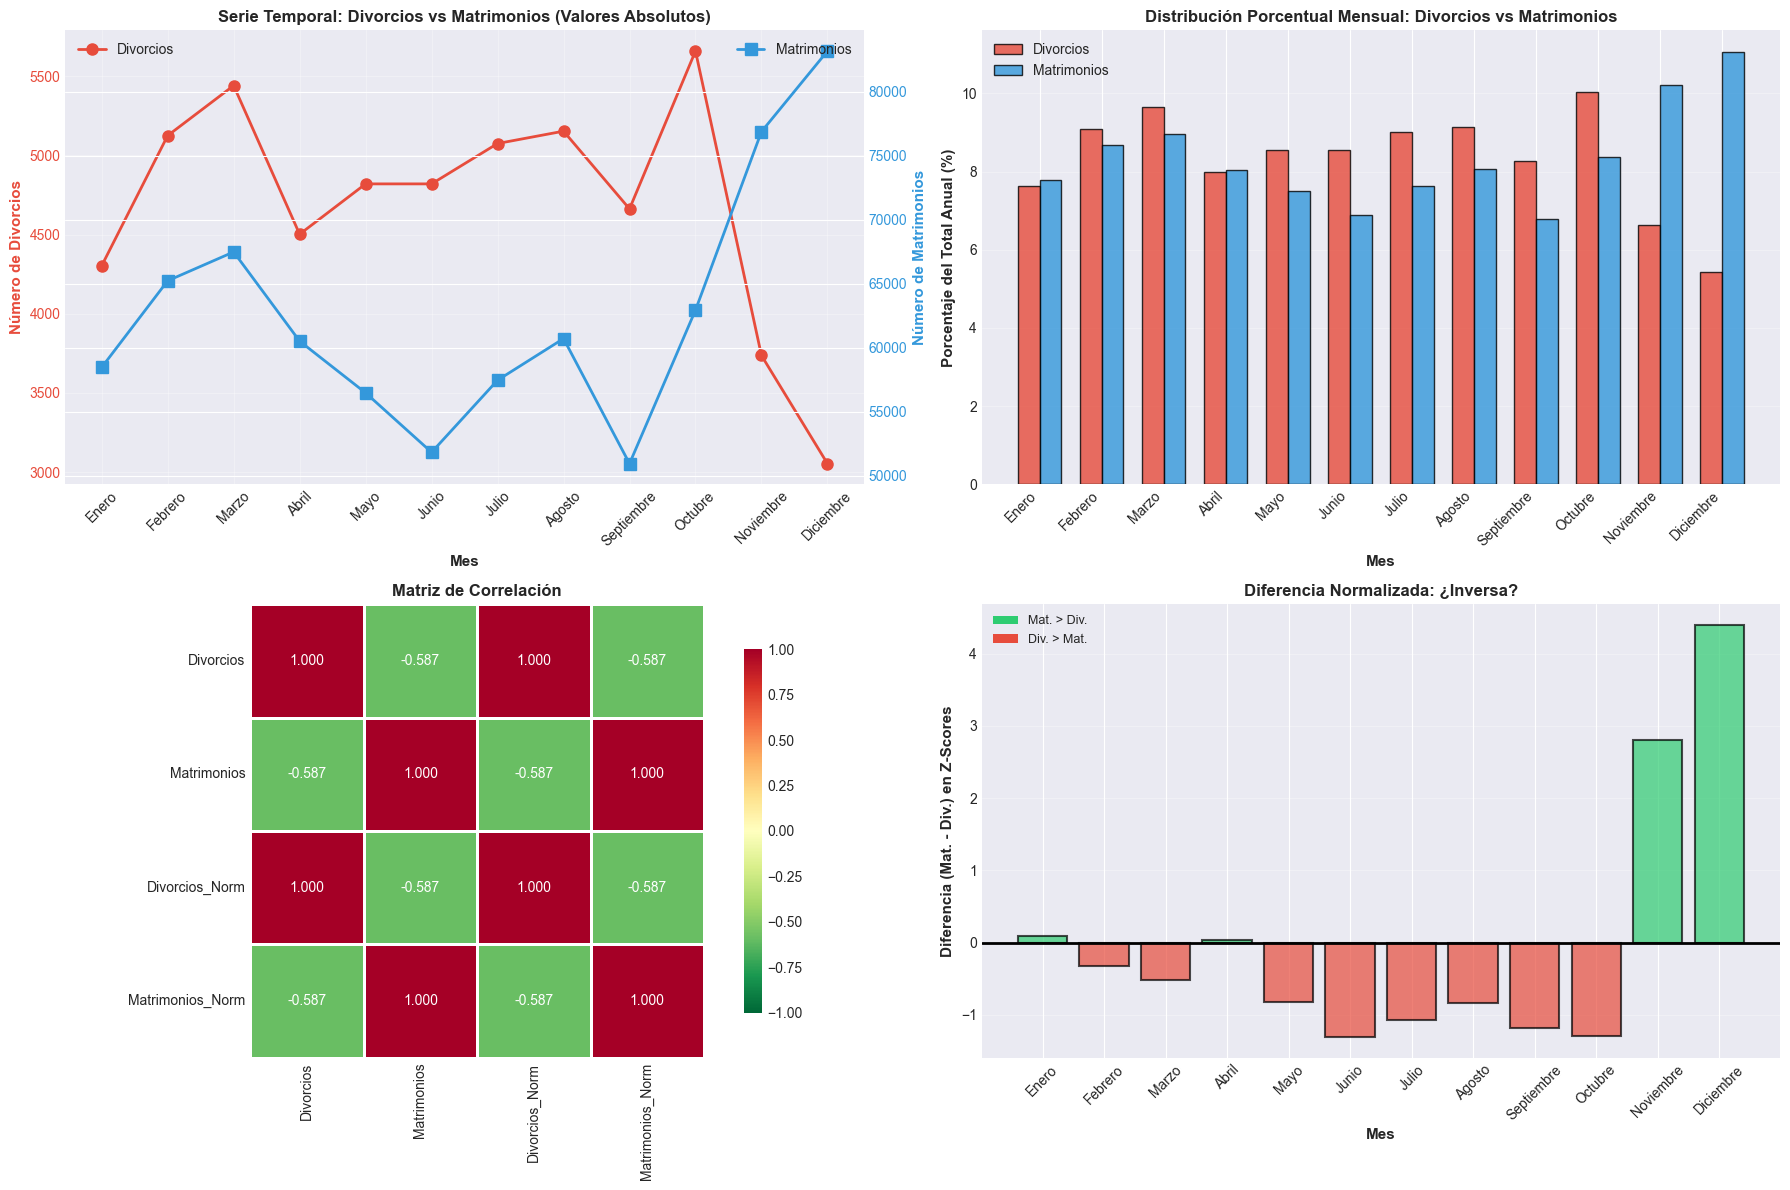

In [12]:
# Crear figura con múltiples subplots
fig = plt.figure(figsize=(18, 12))

# 5.1.1 Series temporales absolutas superpuestas
ax1 = plt.subplot(2, 2, 1)
ax1_twin = ax1.twinx()

ax1.plot(estacionalidad['Mes_Nombre'], estacionalidad['Divorcios'], 
         marker='o', linewidth=2, markersize=8, color='#E74C3C', label='Divorcios')
ax1_twin.plot(estacionalidad['Mes_Nombre'], estacionalidad['Matrimonios'], 
              marker='s', linewidth=2, markersize=8, color='#3498DB', label='Matrimonios')

ax1.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax1.set_ylabel('Número de Divorcios', fontsize=11, fontweight='bold', color='#E74C3C')
ax1_twin.set_ylabel('Número de Matrimonios', fontsize=11, fontweight='bold', color='#3498DB')
ax1.set_title('Serie Temporal: Divorcios vs Matrimonios (Valores Absolutos)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', labelcolor='#E74C3C')
ax1_twin.tick_params(axis='y', labelcolor='#3498DB')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# 5.1.3 Diagrama de barras comparativo
ax3 = plt.subplot(2, 2, 2)
x = np.arange(len(estacionalidad))
width = 0.35

bars1 = ax3.bar(x - width/2, estacionalidad['Divorcios_Pct'], width, 
                label='Divorcios', color='#E74C3C', alpha=0.8, edgecolor='black')
bars2 = ax3.bar(x + width/2, estacionalidad['Matrimonios_Pct'], width, 
                label='Matrimonios', color='#3498DB', alpha=0.8, edgecolor='black')

ax3.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax3.set_ylabel('Porcentaje del Total Anual (%)', fontsize=11, fontweight='bold')
ax3.set_title('Distribución Porcentual Mensual: Divorcios vs Matrimonios', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(estacionalidad['Mes_Nombre'], rotation=45, ha='right')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 5.1.5 Heatmap de correlación
ax5 = plt.subplot(2, 2, 3)
corr_matrix = estacionalidad[['Divorcios', 'Matrimonios', 'Divorcios_Norm', 'Matrimonios_Norm']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=2, cbar_kws={"shrink": 0.8},
            ax=ax5, vmin=-1, vmax=1)
ax5.set_title('Matriz de Correlación', fontsize=12, fontweight='bold')

# 5.1.6 Análisis de diferencias mes a mes
ax6 = plt.subplot(2, 2, 4)
estacionalidad['Diferencia_Norm'] = estacionalidad['Matrimonios_Norm'] - estacionalidad['Divorcios_Norm']
colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in estacionalidad['Diferencia_Norm']]
bars = ax6.bar(estacionalidad['Mes_Nombre'], estacionalidad['Diferencia_Norm'], 
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax6.set_xlabel('Mes', fontsize=11, fontweight='bold')
ax6.set_ylabel('Diferencia (Mat. - Div.) en Z-Scores', fontsize=11, fontweight='bold')
ax6.set_title('Diferencia Normalizada: ¿Inversa?', fontsize=12, fontweight='bold')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3, axis='y')

legend_elements = [Patch(facecolor='#2ECC71', label='Mat. > Div.'),
                   Patch(facecolor='#E74C3C', label='Div. > Mat.')]
ax6.legend(handles=legend_elements, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Clustering: Determinación del Número Óptimo de Clusters

Usamos K-Means para agrupar los meses según su comportamiento en divorcios y matrimonios.

### 6.1 Preparación de Datos para Clustering

In [13]:
# Preparar datos para clustering
X = estacionalidad[['Divorcios', 'Matrimonios']].values

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos preparados para clustering:")
print(f"   - Dimensiones: {X_scaled.shape}")
print(f"   - Features: Divorcios, Matrimonios (normalizados)")

Datos preparados para clustering:
   - Dimensiones: (12, 2)
   - Features: Divorcios, Matrimonios (normalizados)


### 6.2 Método del Codo y Silhouette Score

In [14]:
# Método del codo y silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 8)

print(f"{'K':<5} {'Inercia':<15} {'Silhouette':<15} {'Interpretación'}")
print("="*80)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    if silhouette_avg > 0.7:
        interpretacion = "Excelente"
    elif silhouette_avg > 0.5:
        interpretacion = "Buena"
    elif silhouette_avg > 0.3:
        interpretacion = "Aceptable"
    else:
        interpretacion = "Pobre"
    
    print(f"{k:<5} {kmeans.inertia_:<15.2f} {silhouette_avg:<15.4f} {interpretacion}")

# Determinar mejor K
best_k = K_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print("\n" + "="*80)
print(f"MEJOR NÚMERO DE CLUSTERS: K = {best_k}")
print(f"  Silhouette Score: {best_silhouette:.4f}")

K     Inercia         Silhouette      Interpretación
2     7.00            0.6598          Buena
3     3.03            0.4759          Aceptable
4     2.05            0.4625          Aceptable
5     1.33            0.3732          Aceptable
6     0.76            0.3810          Aceptable
7     0.46            0.3187          Aceptable

MEJOR NÚMERO DE CLUSTERS: K = 2
  Silhouette Score: 0.6598


### 6.3 Visualización del Método del Codo y Silhouette

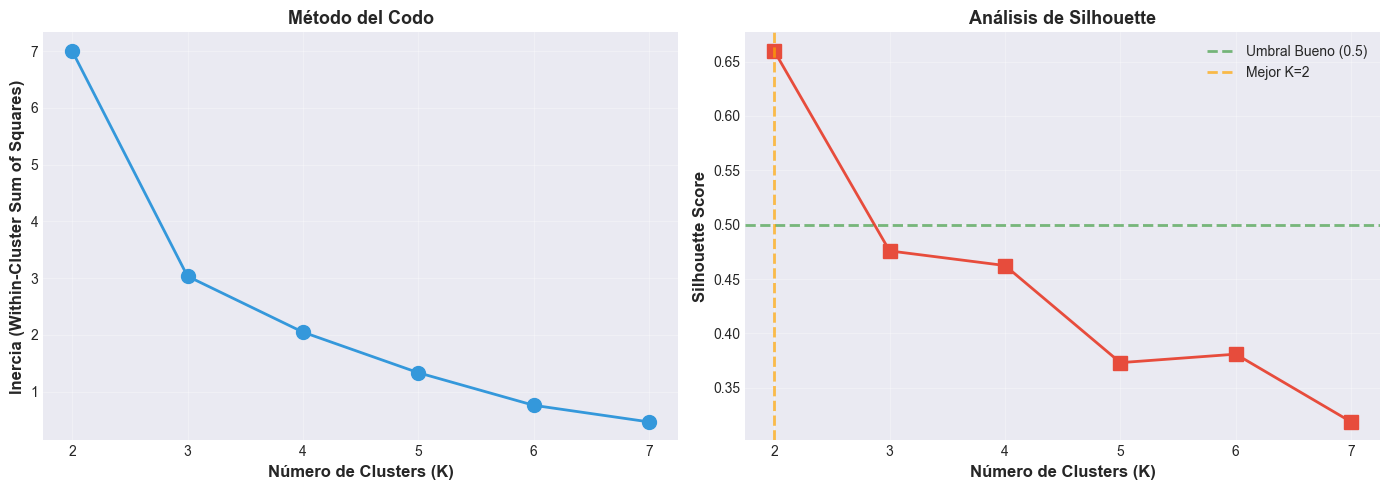

In [15]:
# Visualizar método del codo y silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Método del codo
ax1.plot(K_range, inertias, marker='o', linewidth=2, markersize=10, color='#3498DB')
ax1.set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inercia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
ax1.set_title('Método del Codo', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(K_range)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=10, color='#E74C3C')
ax2.axhline(y=0.5, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Umbral Bueno (0.5)')
ax2.axvline(x=best_k, color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Mejor K={best_k}')
ax2.set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Análisis de Silhouette', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')
ax2.set_xticks(K_range)

plt.tight_layout()
plt.show()

## 7. Aplicar Clustering con K Óptimo

In [16]:
# Aplicar clustering con mejor K
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
estacionalidad['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"✓ Clustering completado con {best_k} clusters")
print(f"\nDistribución de meses por cluster:")
print(estacionalidad['Cluster'].value_counts().sort_index())

✓ Clustering completado con 2 clusters

Distribución de meses por cluster:
Cluster
0    10
1     2
Name: count, dtype: int64


## 8. Verificación de Calidad: Método de la Silueta

In [17]:
# Calcular scores de silueta para cada muestra
silhouette_vals = silhouette_samples(X_scaled, estacionalidad['Cluster'])
silhouette_avg_final = silhouette_score(X_scaled, estacionalidad['Cluster'])

print(f"Silhouette Score Promedio: {silhouette_avg_final:.4f}")
print("\n" + "="*80)
print("Análisis de Silueta por Cluster:")
print(f"{'Cluster':<10} {'N Meses':<12} {'Silhouette Avg':<18} {'Calidad'}")
print("="*80)

for cluster_id in range(best_k):
    cluster_silhouette_vals = silhouette_vals[estacionalidad['Cluster'] == cluster_id]
    cluster_size = len(cluster_silhouette_vals)
    cluster_avg = cluster_silhouette_vals.mean()
    
    if cluster_avg > 0.7:
        calidad = "Excelente"
    elif cluster_avg > 0.5:
        calidad = "Buena"
    elif cluster_avg > 0.3:
        calidad = "Aceptable"
    else:
        calidad = "Pobre"
    
    print(f"{cluster_id:<10} {cluster_size:<12} {cluster_avg:<18.4f} {calidad}")

Silhouette Score Promedio: 0.6598

Análisis de Silueta por Cluster:
Cluster    N Meses      Silhouette Avg     Calidad
0          10           0.6672             Buena
1          2            0.6230             Buena


### 8.1 Diagrama de Silueta

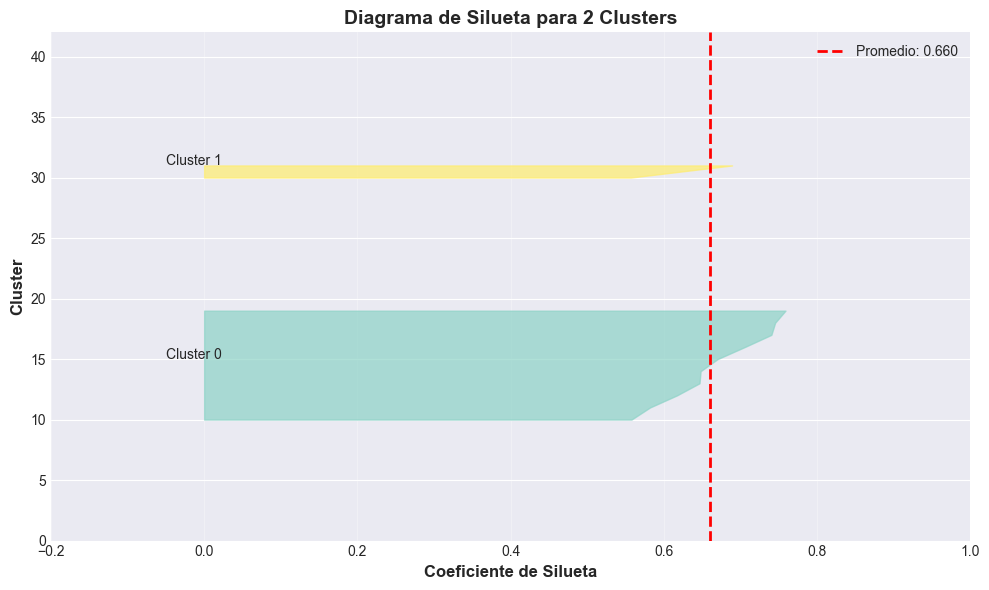

In [18]:
# Visualización del diagrama de silueta
fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
colors = plt.cm.Set3(np.linspace(0, 1, best_k))

for i in range(best_k):
    ith_cluster_silhouette_vals = silhouette_vals[estacionalidad['Cluster'] == i]
    ith_cluster_silhouette_vals.sort()
    
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

ax.set_title(f'Diagrama de Silueta para {best_k} Clusters', fontsize=14, fontweight='bold')
ax.set_xlabel('Coeficiente de Silueta', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.axvline(x=silhouette_avg_final, color="red", linestyle="--", linewidth=2, 
           label=f'Promedio: {silhouette_avg_final:.3f}')
ax.legend(loc='best')
ax.set_xlim([-0.2, 1])
ax.set_ylim([0, len(X_scaled) + (best_k + 1) * 10])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 9. Interpretación de Clusters

Analizamos las características de cada cluster para entender qué meses se agrupan y por qué.

### 9.1 Análisis Estadístico por Cluster

In [19]:
# Análisis detallado por cluster
cluster_analysis = []

for cluster_id in range(best_k):
    cluster_data = estacionalidad[estacionalidad['Cluster'] == cluster_id]
    
    analysis = {
        'Cluster': cluster_id,
        'N_Meses': len(cluster_data),
        'Meses': ', '.join(cluster_data['Mes_Nombre'].tolist()),
        'Div_Promedio': cluster_data['Divorcios'].mean(),
        'Div_Std': cluster_data['Divorcios'].std(),
        'Mat_Promedio': cluster_data['Matrimonios'].mean(),
        'Mat_Std': cluster_data['Matrimonios'].std(),
        'Div_Pct_Total': cluster_data['Divorcios_Pct'].sum(),
        'Mat_Pct_Total': cluster_data['Matrimonios_Pct'].sum(),
        'Ratio_Mat_Div': cluster_data['Matrimonios'].mean() / cluster_data['Divorcios'].mean() if cluster_data['Divorcios'].mean() > 0 else 0
    }
    cluster_analysis.append(analysis)

# Convertir a DataFrame
df_clusters = pd.DataFrame(cluster_analysis)

print("RESUMEN ESTADÍSTICO POR CLUSTER")
print("="*80)
print(df_clusters[['Cluster', 'N_Meses', 'Div_Promedio', 'Mat_Promedio', 'Ratio_Mat_Div']].to_string(index=False))

RESUMEN ESTADÍSTICO POR CLUSTER
 Cluster  N_Meses  Div_Promedio  Mat_Promedio  Ratio_Mat_Div
       0       10        4956.0       59220.8      11.949314
       1        2        3394.5       80028.0      23.575784


### 9.2 Asignación de Nombres Descriptivos a Clusters

In [20]:
# Asignar nombres descriptivos a los clusters
cluster_names = {}
for i, row in df_clusters.iterrows():
    cluster_id = row['Cluster']
    ratio = row['Ratio_Mat_Div']
    
    if ratio > 15:
        name = "TEMPORADA ALTA DE MATRIMONIOS"
    elif ratio < 13:
        name = "TEMPORADA DE DIVORCIOS RELATIVOS"
    else:
        name = "TEMPORADA EQUILIBRADA"
    
    cluster_names[cluster_id] = name

print("\nNOMBRES ASIGNADOS A LOS CLUSTERS:")
print("="*80)
for cid, name in cluster_names.items():
    print(f"Cluster {cid}: {name}")


NOMBRES ASIGNADOS A LOS CLUSTERS:
Cluster 0: TEMPORADA DE DIVORCIOS RELATIVOS
Cluster 1: TEMPORADA ALTA DE MATRIMONIOS


### 9.3 Análisis Detallado de Cada Cluster

In [21]:
# Imprimir análisis detallado
for cluster_id in range(best_k):
    cluster_data = estacionalidad[estacionalidad['Cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {cluster_names[cluster_id]}")
    print(f"{'='*80}")
    
    print(f"\nMeses incluidos ({len(cluster_data)}):")
    print(f"   {', '.join(cluster_data['Mes_Nombre'].tolist())}")
    
    print(f"\nDivorcios:")
    print(f"   Promedio: {cluster_data['Divorcios'].mean():.0f} casos/mes")
    print(f"   Rango: {cluster_data['Divorcios'].min():.0f} - {cluster_data['Divorcios'].max():.0f}")
    print(f"   % del total anual: {cluster_data['Divorcios_Pct'].sum():.2f}%")
    print(f"   Z-score promedio: {cluster_data['Divorcios_Norm'].mean():.3f}")
    
    print(f"\nMatrimonios:")
    print(f"   Promedio: {cluster_data['Matrimonios'].mean():.0f} casos/mes")
    print(f"   Rango: {cluster_data['Matrimonios'].min():.0f} - {cluster_data['Matrimonios'].max():.0f}")
    print(f"   % del total anual: {cluster_data['Matrimonios_Pct'].sum():.2f}%")
    print(f"   Z-score promedio: {cluster_data['Matrimonios_Norm'].mean():.3f}")
    
    ratio = cluster_data['Matrimonios'].mean() / cluster_data['Divorcios'].mean()
    print(f"\nRatio Matrimonios/Divorcios: {ratio:.2f}:1")
    
    # Características especiales
    if 11 in cluster_data['Mes'].values or 12 in cluster_data['Mes'].values:
        print(f"\nCARACTERÍSTICAS ESPECIALES:")
        print(f"Incluye temporada festiva (Nov-Dic)")
        if cluster_data['Matrimonios_Norm'].mean() > 0.5:
            print(f"Alta actividad matrimonial")
        if cluster_data['Divorcios_Norm'].mean() < -0.3:
            print(f"Baja actividad de divorcios")


CLUSTER 0: TEMPORADA DE DIVORCIOS RELATIVOS

Meses incluidos (10):
   Enero, Febrero, Marzo, Abril, Mayo, Junio, Julio, Agosto, Septiembre, Octubre

Divorcios:
   Promedio: 4956 casos/mes
   Rango: 4303 - 5659
   % del total anual: 87.95%
   Z-score promedio: 0.356

Matrimonios:
   Promedio: 59221 casos/mes
   Rango: 50967 - 67492
   % del total anual: 78.72%
   Z-score promedio: -0.364

Ratio Matrimonios/Divorcios: 11.95:1

CLUSTER 1: TEMPORADA ALTA DE MATRIMONIOS

Meses incluidos (2):
   Noviembre, Diciembre

Divorcios:
   Promedio: 3394 casos/mes
   Rango: 3053 - 3736
   % del total anual: 12.05%
   Z-score promedio: -1.782

Matrimonios:
   Promedio: 80028 casos/mes
   Rango: 76882 - 83174
   % del total anual: 21.28%
   Z-score promedio: 1.821

Ratio Matrimonios/Divorcios: 23.58:1

CARACTERÍSTICAS ESPECIALES:
Incluye temporada festiva (Nov-Dic)
Alta actividad matrimonial
Baja actividad de divorcios


### 9.4 Visualizaciones de Clusters

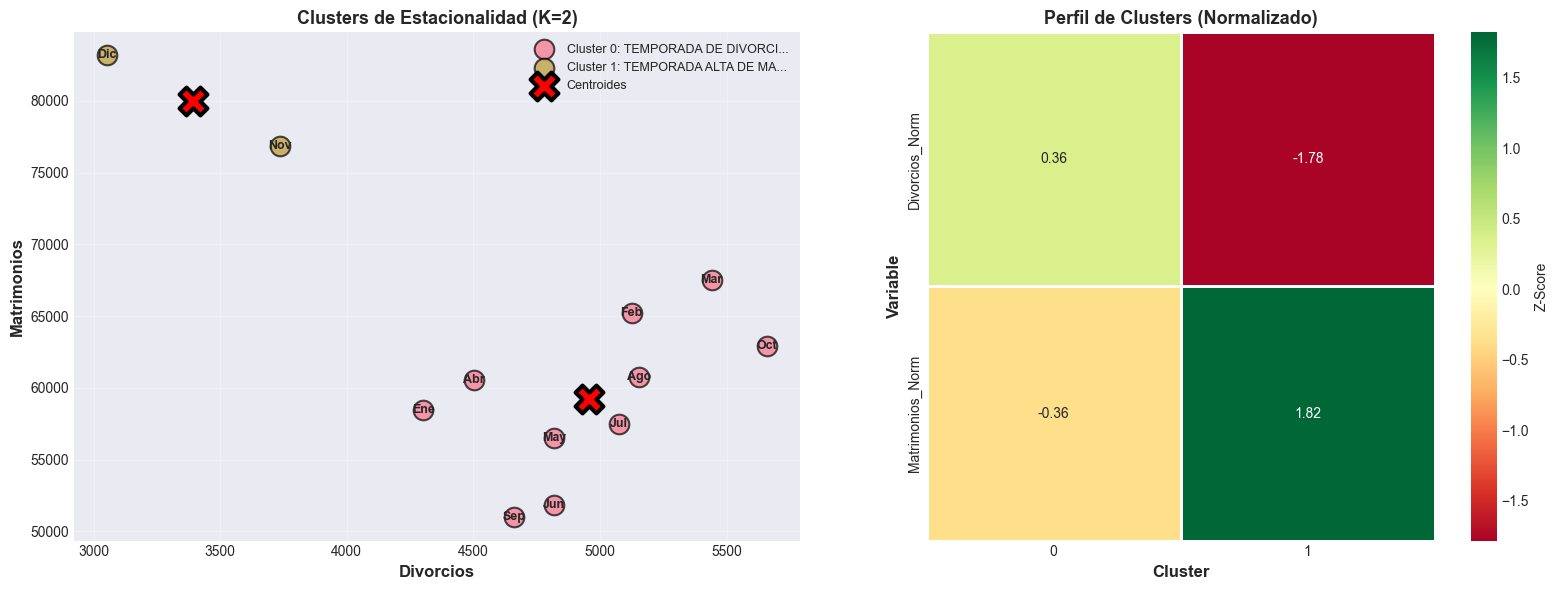

In [22]:
# Visualización de clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 9.4.1 Scatter plot de clusters
ax1 = axes[0]
for cluster_id in range(best_k):
    cluster_data = estacionalidad[estacionalidad['Cluster'] == cluster_id]
    ax1.scatter(cluster_data['Divorcios'], cluster_data['Matrimonios'],
               s=200, alpha=0.7, label=f'Cluster {cluster_id}: {cluster_names[cluster_id][:20]}...',
               edgecolors='black', linewidth=1.5)
    
    for _, row in cluster_data.iterrows():
        ax1.annotate(row['Mes_Nombre'][:3], 
                    (row['Divorcios'], row['Matrimonios']),
                    fontsize=9, ha='center', va='center', fontweight='bold')

centroides = scaler.inverse_transform(kmeans_final.cluster_centers_)
ax1.scatter(centroides[:, 0], centroides[:, 1], 
           s=400, marker='X', c='red', edgecolors='black', 
           linewidth=3, label='Centroides', zorder=10)

ax1.set_xlabel('Divorcios', fontsize=12, fontweight='bold')
ax1.set_ylabel('Matrimonios', fontsize=12, fontweight='bold')
ax1.set_title(f'Clusters de Estacionalidad (K={best_k})', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# 9.4.2 Heatmap de características por cluster
ax2 = axes[1]
cluster_features = estacionalidad.groupby('Cluster')[['Divorcios_Norm', 'Matrimonios_Norm']].mean()
sns.heatmap(cluster_features.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, ax=ax2, cbar_kws={'label': 'Z-Score'},
            linewidths=2, square=True)
ax2.set_title('Perfil de Clusters (Normalizado)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax2.set_ylabel('Variable', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Validación de Hipótesis

Validamos la hipótesis usando 4 criterios independientes.

In [23]:
print("🔬 HIPÓTESIS PLANTEADA:")
print("="*80)
print("'Existe un patrón estacional opuesto entre matrimonios y divorcios:")
print(" los matrimonios alcanzan su pico en noviembre-diciembre (temporada festiva)")
print(" mientras que los divorcios presentan su mínimo en estos mismos meses'")
print("\n📊 EVIDENCIA ENCONTRADA:")
print("="*80)

🔬 HIPÓTESIS PLANTEADA:
'Existe un patrón estacional opuesto entre matrimonios y divorcios:
 los matrimonios alcanzan su pico en noviembre-diciembre (temporada festiva)
 mientras que los divorcios presentan su mínimo en estos mismos meses'

📊 EVIDENCIA ENCONTRADA:


### 10.1 Criterio 1: Correlación Negativa

In [24]:
print("\n1. CORRELACIÓN ENTRE VARIABLES:")
if pearson_r < 0:
    print(f"   ✓ Se encontró correlación NEGATIVA (r = {pearson_r:.4f})")
    print(f"   ✓ Significancia estadística: p = {pearson_p:.6f}")
    validacion_1 = True
else:
    print(f"   ✗ Se encontró correlación POSITIVA (r = {pearson_r:.4f})")
    print(f"   ✗ Contrario a la hipótesis de estacionalidad inversa")
    validacion_1 = False


1. CORRELACIÓN ENTRE VARIABLES:
   ✓ Se encontró correlación NEGATIVA (r = -0.5867)
   ✓ Significancia estadística: p = 0.044933


### 10.2 Criterio 2: Comportamiento en Temporada Festiva

In [25]:
print("\n2. COMPORTAMIENTO EN TEMPORADA FESTIVA (NOV-DIC):")
nov_dic_mat = estacionalidad[estacionalidad['Mes'].isin([11, 12])]['Matrimonios'].sum()
nov_dic_div = estacionalidad[estacionalidad['Mes'].isin([11, 12])]['Divorcios'].sum()
nov_dic_mat_pct = (nov_dic_mat / estacionalidad['Matrimonios'].sum()) * 100
nov_dic_div_pct = (nov_dic_div / estacionalidad['Divorcios'].sum()) * 100

print(f"   Matrimonios Nov-Dic: {nov_dic_mat:,} ({nov_dic_mat_pct:.2f}% del total anual)")
print(f"   Divorcios Nov-Dic: {nov_dic_div:,} ({nov_dic_div_pct:.2f}% del total anual)")

if mat_max['Mes'] in [11, 12]:
    print(f"   ✓ Pico de matrimonios en {mat_max['Mes_Nombre']}")
    validacion_2a = True
else:
    print(f"   ✗ Pico de matrimonios en {mat_max['Mes_Nombre']} (no en Nov-Dic)")
    validacion_2a = False

if div_min['Mes'] in [11, 12]:
    print(f"   ✓ Mínimo de divorcios en {div_min['Mes_Nombre']}")
    validacion_2b = True
else:
    print(f"   ✗ Mínimo de divorcios en {div_min['Mes_Nombre']} (no en Nov-Dic)")
    validacion_2b = False

validacion_2 = validacion_2a and validacion_2b


2. COMPORTAMIENTO EN TEMPORADA FESTIVA (NOV-DIC):
   Matrimonios Nov-Dic: 160,056 (21.28% del total anual)
   Divorcios Nov-Dic: 6,789 (12.05% del total anual)
   ✓ Pico de matrimonios en Diciembre
   ✓ Mínimo de divorcios en Diciembre


### 10.3 Criterio 3: Análisis de Series Normalizadas

In [26]:
print("\n3. ANÁLISIS DE SERIES NORMALIZADAS:")
nov_dic_norm = estacionalidad[estacionalidad['Mes'].isin([11, 12])]
mat_norm_avg = nov_dic_norm['Matrimonios_Norm'].mean()
div_norm_avg = nov_dic_norm['Divorcios_Norm'].mean()

print(f"   Z-score promedio de Matrimonios en Nov-Dic: {mat_norm_avg:.3f}")
print(f"   Z-score promedio de Divorcios en Nov-Dic: {div_norm_avg:.3f}")

if mat_norm_avg > 0.5 and div_norm_avg < -0.3:
    print(f"   ✓ Patrón inverso detectado: Matrimonios alto, Divorcios bajo")
    validacion_3 = True
else:
    print(f"   ✗ No se detecta patrón inverso claro en la temporada festiva")
    validacion_3 = False


3. ANÁLISIS DE SERIES NORMALIZADAS:
   Z-score promedio de Matrimonios en Nov-Dic: 1.821
   Z-score promedio de Divorcios en Nov-Dic: -1.782
   ✓ Patrón inverso detectado: Matrimonios alto, Divorcios bajo


### 10.4 Criterio 4: Clustering y Patrones

In [27]:
print("\n4. AGRUPAMIENTO Y PATRONES:")
print(f"   Número óptimo de clusters: {best_k}")
print(f"   Calidad del clustering (Silhouette): {silhouette_avg_final:.4f}")

cluster_festivo = estacionalidad[estacionalidad['Mes'].isin([11, 12])]['Cluster'].mode()[0]
cluster_festivo_data = estacionalidad[estacionalidad['Cluster'] == cluster_festivo]

if cluster_festivo_data['Matrimonios_Norm'].mean() > 0 and cluster_festivo_data['Divorcios_Norm'].mean() < 0:
    print(f"   ✓ Cluster {cluster_festivo} muestra patrón inverso en temporada festiva")
    validacion_4 = True
else:
    print(f"   ✗ Cluster {cluster_festivo} no muestra patrón inverso claro")
    validacion_4 = False


4. AGRUPAMIENTO Y PATRONES:
   Número óptimo de clusters: 2
   Calidad del clustering (Silhouette): 0.6598
   ✓ Cluster 1 muestra patrón inverso en temporada festiva


### 10.5 Conclusión Final

In [28]:
# CONCLUSIÓN FINAL
validaciones = [validacion_1, validacion_2, validacion_3, validacion_4]
porcentaje_validacion = (sum(validaciones) / len(validaciones)) * 100

print("\n" + "="*80)
print("CONCLUSIÓN FINAL")
print("="*80)
print(f"\nCriterios validados: {sum(validaciones)}/{len(validaciones)} ({porcentaje_validacion:.1f}%)")

if porcentaje_validacion >= 75:
    conclusion = "✓ HIPÓTESIS CONFIRMADA"
    print(f"\n{conclusion}")
    print("La evidencia estadística RESPALDA la hipótesis de estacionalidad inversa.")
    print("Se observa un patrón donde los matrimonios aumentan significativamente en")
    print("la temporada festiva (Nov-Dic) mientras que los divorcios disminuyen.")
elif porcentaje_validacion >= 50:
    conclusion = "⚠️ HIPÓTESIS PARCIALMENTE CONFIRMADA"
    print(f"\n{conclusion}")
    print("La evidencia muestra APOYO PARCIAL a la hipótesis de estacionalidad inversa.")
    print("Algunos criterios se cumplen, pero otros requieren mayor investigación.")
else:
    conclusion = "✗ HIPÓTESIS REFUTADA"
    print(f"\n{conclusion}")
    print("La evidencia NO respalda la hipótesis de estacionalidad inversa.")
    print("Los datos sugieren patrones estacionales diferentes a los esperados.")


CONCLUSIÓN FINAL

Criterios validados: 4/4 (100.0%)

✓ HIPÓTESIS CONFIRMADA
La evidencia estadística RESPALDA la hipótesis de estacionalidad inversa.
Se observa un patrón donde los matrimonios aumentan significativamente en
la temporada festiva (Nov-Dic) mientras que los divorcios disminuyen.
